# Multivariable Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import linregress, t, norm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Understanding MLR Coefficient Interpretations

Here we plot a response variable (Y) that depends on two explanatory variables (X1 and X2)

<IPython.core.display.Javascript object>


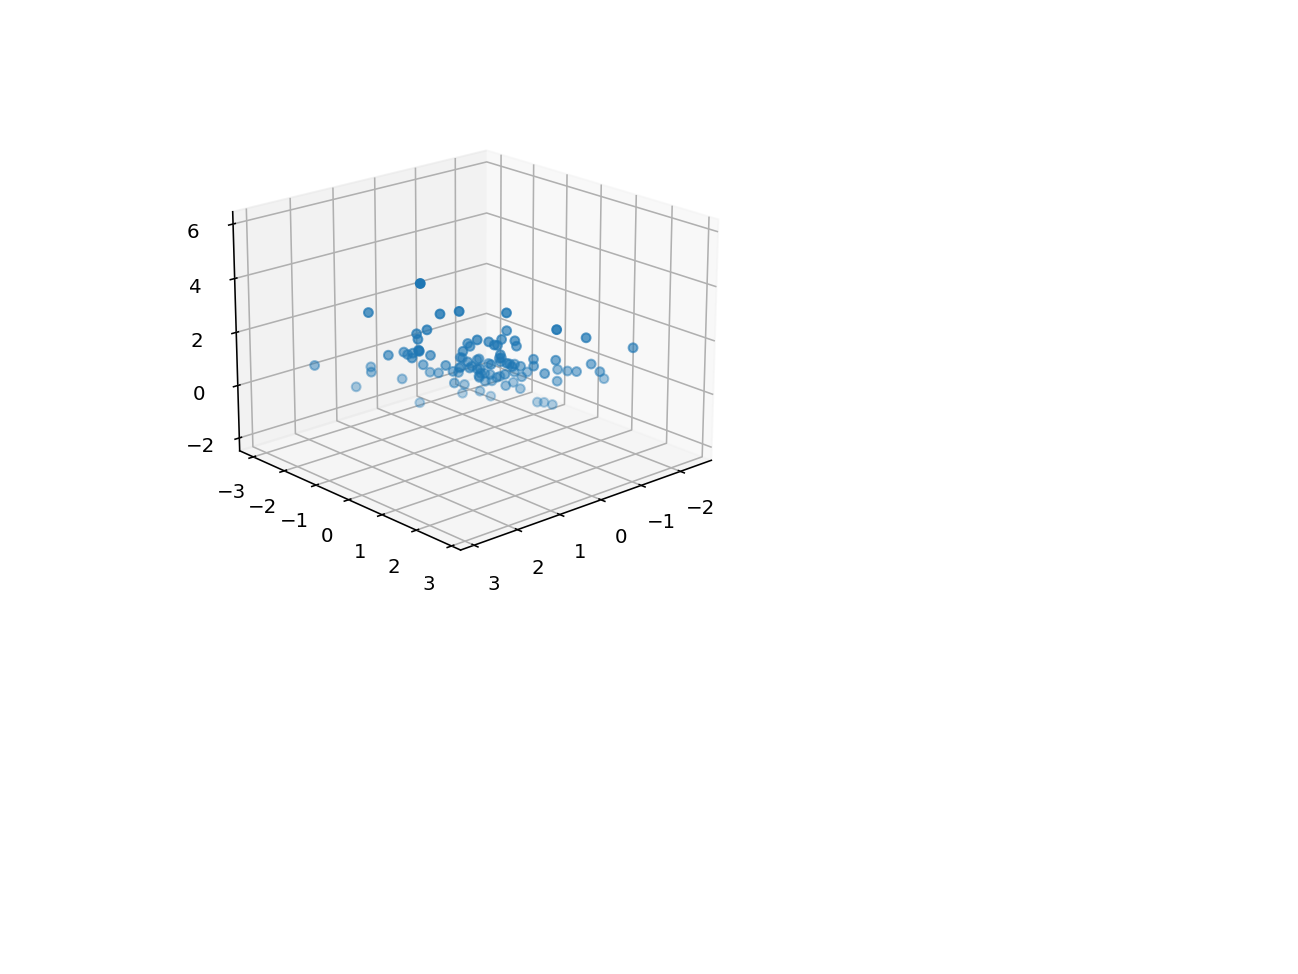

In [2]:
%matplotlib notebook
n = 100
x1 = np.random.randn(n)
x2 = np.random.randn(n)

y = 1 + x1 + x2 + np.random.randn(n)*0.3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, y)
plt.show()

In [3]:
%matplotlib inline

Here we plot 3 2D projections of the 3d data

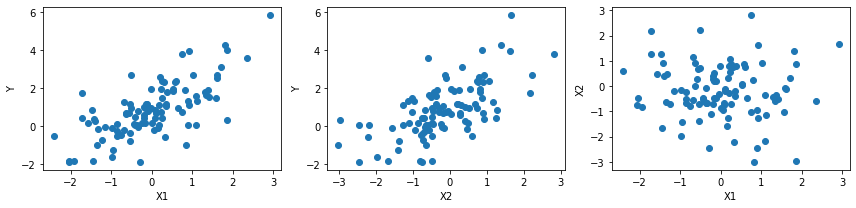

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
i = 1
for ax, x in zip(axs, [x1, x2]):
    ax.scatter(x=x, y=y)
    ax.set_xlabel(f'X{i}')
    ax.set_ylabel('Y')
    i += 1

ax1 = axs[2]
ax1.scatter(x=x1, y=x2)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
plt.show()

In [5]:
# Get the residuals after regressing y to x
def get_residuals(x, y):
    fit = linregress(x, y)
    m = fit.slope
    b = fit.intercept
    y_hat = m*x + b

    residuals = y - y_hat
    
    return residuals

Here we compute the coefficients by removing the effect of each varfiable from the response and the other explanatory variable. Ex: To compute $\beta_1$ we remove the effect of X2 from X1 and Y, i.e., regress to X2 and take the residuals, and then regress the residuals of Y to the residuals of X1.

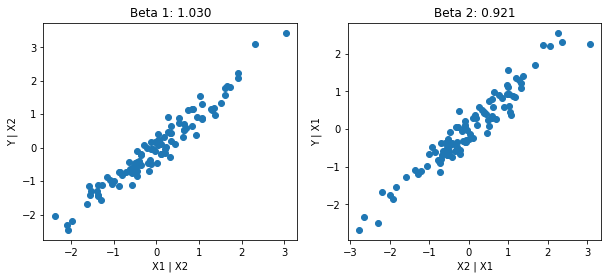

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Removing X2 effect from Y and X1 to get Beta1
y_res = get_residuals(x2, y)
x1_res = get_residuals(x2, x1)
fit = linregress(x1_res, y_res)
ax0 = axs[0]
ax0.scatter(x=x1_res, y=y_res)
ax0.set_title(f'Beta 1: {fit.slope:.3f}')
ax0.set_xlabel('X1 | X2')
ax0.set_ylabel('Y | X2')

# Removing X1 effect from Y and X2 to get Beta2
y_res = get_residuals(x1, y)
x2_res = get_residuals(x1, x2)
fit = linregress(x2_res, y_res)
ax1 = axs[1]
ax1.scatter(x=x2_res, y=y_res)
ax1.set_title(f'Beta 2: {fit.slope:.3f}')
ax1.set_xlabel('X2 | X1')
ax1.set_ylabel('Y | X1')
plt.show()

Comparing the manally computed coefficents to `scikit-learn` LinearRegression

In [7]:
# Fitting maltivariable linear regression model

X = np.array([x1, x2]).T
mlr_fit = LinearRegression()
mlr_fit.fit(X, y)

print(f'Coefficients: {mlr_fit.coef_}')
print(f'Intercept: {mlr_fit.intercept_}')

Coefficients: [1.0301663  0.92143884]
Intercept: 1.0303114076022282


## Simpson's Paradox and Confounding Variables
See [this](https://www.youtube.com/watch?v=SFPM9IuP2m8&list=PLpl-gQkQivXjqHAJd2t-J_One_fYE55tC&index=2) video on adjustment and chapter "Adjustment".

In [8]:
x1 = np.linspace(1, 100, 100)
x2 = 0.1 * x1 + np.random.randn(100)
y = x1 - x2 + np.random.randn(100)*3

X = np.array([x1, x2]).T

We first fit a linear model using X2 only. Notice that the coefficient is positive whereas in reality it should be -1.

In [9]:
# Fitting a linear model using X2 only
lr=  LinearRegression().fit(x2.reshape(-1, 1), y)
lr.coef_

array([7.8355136])

When we fit a model using both variables we get approximately the true coefficients.

In [10]:
# Fitting a linear model using both variables
lr = LinearRegression().fit(X, y)
lr.coef_

array([ 0.9717179 , -0.84568431])

In [11]:
X_sm = sm.add_constant(X)
mod = sm.OLS(y, X_sm)
mod = mod.fit()
mod.params

array([ 0.39609632,  0.9717179 , -0.84568431])

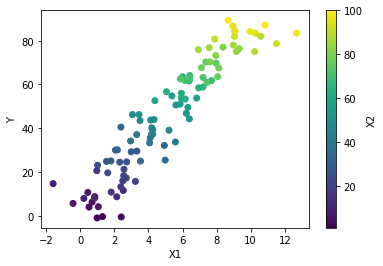

In [12]:
plt.scatter(x=x2, y=y, c=x1)
plt.colorbar(label='X2')
plt.xlabel('X1')
plt.ylabel('Y')
plt.show()

After removing X1 from X2 and Y, we get the real negative relationship between X2 and Y

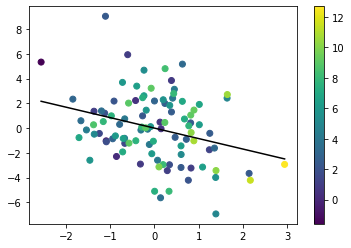

In [13]:
y_res = get_residuals(x1, y)
x2_res = get_residuals(x1, x2)
plt.scatter(x=x2_res, y=y_res, c=x2)
fit = linregress(x2_res, y_res)
x_fit = np.linspace(x2_res.min(), x2_res.max(), 10)
y_fit = fit.slope * x_fit + fit.intercept
plt.plot(x_fit, y_fit, color='black')
plt.colorbar()
plt.show()

This demonstrates the importance of choosing the right variables. Using only X2, we would have concluded that X2 positively correlates (or maybe causes) Y, when in reality they are negatively correlated. X1 is a confounding variable, i.e., it influences both the target variable and the independent variable. [See Wikipedia](https://en.wikipedia.org/wiki/Confounding)

### Regressing Dummy Variables
Dummy variables are binary variables, i.e., take the values 0 or 1 only.

We use the Insect Sprays dataset which counts the number of killed insects using different types of sprays.

In [16]:
# Loading the insect spray dataset
df = pd.read_csv('data/InsectSprays.csv', index_col=[0])
df.head(2)

,count,spray
1,10,A
2,7,A


In [17]:
# Creating dummy variable columns for each spray
df = pd.concat([df, pd.get_dummies(df['spray'])], axis=1)

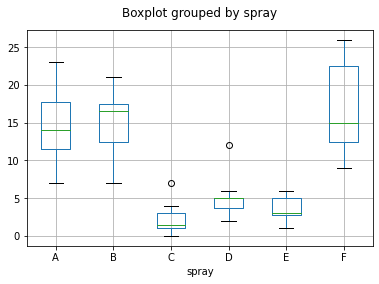

In [18]:
df[['count', 'spray']].boxplot(column='count', by='spray')
plt.title(None)
plt.show()

First we fit a model to predict the number of killed insects without an intercept. In this case, each coefficient is the mean of the corresponding spray, and the t-test tests the null hypothesis that the number of killed insects is 0.

In [19]:
# Fitting a linear model to the data
X = df[['A', 'B', 'C', 'D', 'E', 'F']]
y = df['count']

fit = sm.OLS(y, X)
fit = fit.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     34.70
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           3.18e-17
Time:                        21:54:17   Log-Likelihood:                -197.42
No. Observations:                  72   AIC:                             406.8
Df Residuals:                      66   BIC:                             420.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A             14.5000      1.132     12.807      0.000      12.240      16.760
B             15.3333      1.132     13.543      0.000      13.073      17.594
C              2.0833      1.132      1.840      0.070      -0.177       4.344
D              4.9167      1.132      4.343      0.000       2.656       7.177
E              3.5000      1.132      3.091      0.003       1.240       5.760
F             16.6667      1.132     14.721      0.000      14.406      18.927
==============================================================================
Omnibus:                        3.201   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                2.421
Skew:                           0.411   Prob(JB):                        0.298
Kurtosis:                       3.360   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Mean count of each spray
df.groupby('spray').mean()[['count']]

,count
spray,
A,14.500000
B,15.333333
C,2.083333
D,4.916667
E,3.500000
F,16.666667


Next, we fit the model using an intercept and we omit one of the dummy variables to avoid multicollinearity. The omitted spray would be represented by the intercept and all other values are changes from this spray. Thus, this spray is now the reference spray. Furthermore, all conducted t-tests test the null hypothesis that the mean count of kills for each sprays equals that of the reference spray. The t-test of the reference spray, i.e., the intercept tests the null hypothesis that its kill counts is 0.

In [21]:
ref_spray = 'B'

X = df[['A', 'B', 'C', 'D', 'E', 'F']].drop(columns=[ref_spray])
X = sm.add_constant(X)
y = df['count'].to_numpy()

fit = sm.OLS(y, X)
fit = fit.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     34.70
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           3.18e-17
Time:                        21:54:43   Log-Likelihood:                -197.42
No. Observations:                  72   AIC:                             406.8
Df Residuals:                      66   BIC:                             420.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.3333      1.132     13.543      0.000      13.073      17.594
A             -0.8333      1.601     -0.520      0.604      -4.030       2.363
C            -13.2500      1.601     -8.276      0.000     -16.447     -10.053
D            -10.4167      1.601     -6.506      0.000     -13.613      -7.220
E            -11.8333      1.601     -7.391      0.000     -15.030      -8.637
F              1.3333      1.601      0.833      0.408      -1.863       4.530
==============================================================================
Omnibus:                        3.201   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                2.421
Skew:                           0.411   Prob(JB):                        0.298
Kurtosis:                       3.360   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Including interaction variables
In this section, we will use the `swiss` dataset. Read about this dataset [here](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/swiss.html)

In [22]:
df = pd.read_csv('data/swiss.csv')

In [23]:
df.head()

,Location,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
0,Courtelary,80.2,17.0,15,12,9.96,22.2
1,Delemont,83.1,45.1,6,9,84.84,22.2
2,Franches-Mnt,92.5,39.7,5,5,93.40,20.2
3,Moutier,85.8,36.5,12,7,33.77,20.3
4,Neuveville,76.9,43.5,17,15,5.16,20.6


First, we fit a model to predict Fertility using Agriculture (% of men that work in agriculture)

In [24]:
X = df[['Agriculture']]
X = sm.add_constant(X)
y = df['Fertility']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fertility   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     6.409
Date:                Fri, 01 Jul 2022   Prob (F-statistic):             0.0149
Time:                        21:55:02   Log-Likelihood:                -181.73
No. Observations:                  47   AIC:                             367.5
Df Residuals:                      45   BIC:                             371.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.3044      4.251     14.185      0.000      51.742      68.867
Agriculture     0.1942      0.077      2.532      0.015       0.040       0.349
==============================================================================
Omnibus:                        0.295   Durbin-Watson:                   0.646
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.481
Skew:                          -0.095   Prob(JB):                        0.786
Kurtosis:                       2.542   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
def plot_fit(ax, x, y, params, color=None):
    
    x_coord = np.linspace(x.min(), x.max(), 3)
    y_hat = params[0] + x_coord*params[1]
    
    if color is None:
        color = 'black'
    ax.plot(x_coord, y_hat, color=color)

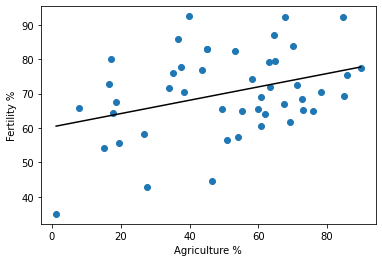

In [28]:
fig, ax = plt.subplots()
params = model.params.to_list()
plot_fit(ax, X['Agriculture'], y, params)
ax.scatter(x=X['Agriculture'], y=y)
ax.set_xlabel('Agriculture %')
ax.set_ylabel('Fertility %')

plt.show()

The model suggests that the for every 1% increase in agriculture, Fertility increases by 0.19%, starting from a reference of Fertility=60.3 (the intercept) 

Next, we include the variable Catholic, which is the percentage of Catholics in the province. Lets take a look at the distribution of this variable.

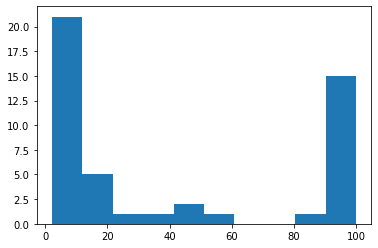

In [29]:
plt.hist(df['Catholic'])
plt.show()

Notice that most provinces are either totally Catholic or totally Protestant. Therefore, a dummy variable `catholic` will be created to refer to the province as Catholic or not.

In [30]:
df['catholic'] = (df['Catholic'] > 50) * 1

Now we fit a model using Agriculture and the new binary catholic variable.

In [31]:
X = df[['Agriculture', 'catholic']]
X = sm.add_constant(X)
y = df['Fertility']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fertility   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     5.660
Date:                Fri, 01 Jul 2022   Prob (F-statistic):            0.00649
Time:                        21:55:39   Log-Likelihood:                -179.48
No. Observations:                  47   AIC:                             365.0
Df Residuals:                      44   BIC:                             370.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.8322      4.106     14.816      0.000      52.557      69.107
Agriculture     0.1242      0.081      1.531      0.133      -0.039       0.288
catholic        7.8843      3.748      2.103      0.041       0.330      15.439
==============================================================================
Omnibus:                        6.176   Durbin-Watson:                   0.703
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                4.983
Skew:                          -0.696   Prob(JB):                       0.0828
Kurtosis:                       3.778   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this case, the coefficient of `catholic` modifies the intercept. When `catholic` = 0, this coefficient does not appear. When `catholic` = 1, the intercept would be the sum of the original intercept and the value of `catholic` coefficient

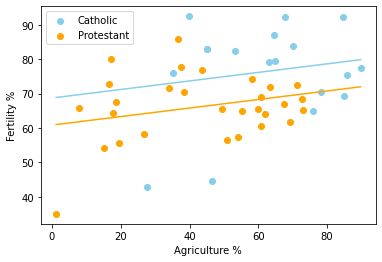

In [32]:
fig, ax = plt.subplots()
params = model.params.to_list()


# Plotting catholic provinces
cond = X['catholic'] == 1
ax.scatter(x=X.loc[cond, 'Agriculture'], y=y[cond], c='skyblue', label='Catholic')

# When a province is catholic, the intercept is the sum of the original intercept
# and "catholic" coefficient (Remember catholic is either 0 or 1)
cath_params = [params[0] + params[2], params[1]]
plot_fit(ax, X['Agriculture'], y, cath_params, color='skyblue')

# Plotting Protestant provinces
ax.scatter(x=X.loc[~cond, 'Agriculture'], y=y[~cond], c='orange', label='Protestant')
prot_params = params[:2]
plot_fit(ax, X['Agriculture'], y, prot_params, color='orange')

ax.set_xlabel('Agriculture %')
ax.set_ylabel('Fertility %')

ax.legend()
plt.show()

Now we add an interaction variable to modify the slope of the fitted line based on the value of `catholic`.

In [33]:
X = df[['Agriculture', 'catholic']].copy()
X.loc[:, 'interaction'] = X['Agriculture'] * X['catholic']
X = sm.add_constant(X)
y = df['Fertility']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Fertility   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     3.795
Date:                Fri, 01 Jul 2022   Prob (F-statistic):             0.0168
Time:                        21:56:26   Log-Likelihood:                -179.34
No. Observations:                  47   AIC:                             366.7
Df Residuals:                      43   BIC:                             374.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          62.0499      4.789     12.956      0.000      52.392      71.708
Agriculture     0.0961      0.099      0.973      0.336      -0.103       0.295
catholic        2.8577     10.626      0.269      0.789     -18.573      24.288
interaction     0.0891      0.176      0.506      0.615      -0.266       0.444
==============================================================================
Omnibus:                        4.986   Durbin-Watson:                   0.700
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                3.815
Skew:                          -0.637   Prob(JB):                        0.148
Kurtosis:                       3.569   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this model, not only the intercept is dependent on the `catholic` variable, even the slope depends on it. When `catholic`=1, the slope is equal to the sum of the original slope and the `interaction` coefficent.

In [34]:
model.params

const          62.049930
Agriculture     0.096116
catholic        2.857704
interaction     0.089135
dtype: float64

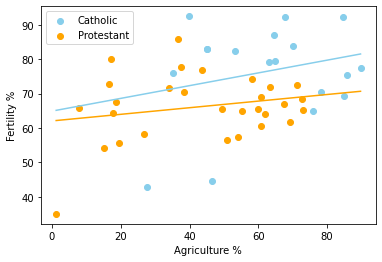

In [35]:
fig, ax = plt.subplots()
params = model.params


# Plotting catholic provinces
cond = X['catholic'] == 1
ax.scatter(x=X.loc[cond, 'Agriculture'], y=y[cond], c='skyblue', label='Catholic')

# When a province is catholic, the intercept is the sum of the original intercept
# and "catholic" coefficient (Remember catholic is either 0 or 1)
# and the intercept is the sum of the original slope and the interaction slope
cath_params = [params['const'] + params['catholic'], # Intercept
               params['Agriculture'] + params['interaction']] # Slope

plot_fit(ax, X['Agriculture'], y, cath_params, color='skyblue')

# Plotting Protestant provinces
ax.scatter(x=X.loc[~cond, 'Agriculture'], y=y[~cond], c='orange', label='Protestant')
prot_params = [params['const'], params['Agriculture']]

plot_fit(ax, X['Agriculture'], y, prot_params, color='orange')

ax.set_xlabel('Agriculture %')
ax.set_ylabel('Fertility %')

ax.legend()
plt.show()

### Adjustment
See [this](https://www.youtube.com/watch?v=SFPM9IuP2m8&list=PLpl-gQkQivXjqHAJd2t-J_One_fYE55tC&index=26) video on examples of adjusting for a variable **and read the corresponding chapter in the book**

### Residuals, Variation, Daignostics
**IMPORTANT SECTION** (Most of the definitions here are directly taken from the book "Regression Models for Data Science" by Brian Caffo.

In this section, the different statistics used for regression diagnostics are discussed. Important terms:
* **Leverage** can be thought of as the distance between the point and the bulk of the other points measured using the independent variables (X). Points with high leverage have the potential to dramatically impact the regression fit, although it may not do so if it falls near the fitted hyperplane. The measure used to explore leverage is **hat diagonals**, which ranges between zero and one for a high leverage value.

* **Influence** is a measure of how much impact a point has on the regression fit. The most direct way to measure influence is fit the model with the point included and excluded. Influence is measured by several statistics:
    * `dffits`: Change in the predicted response when the ith point is deleted in fitting the model.
    * `dfbetas`: Change in individual coefficients when the ith point is deleted in fitting the model.
    * `cooks_distance`: Overall change in the coefficients when the ith point is deleted.
    
To get these measures using statsmodels reun the method `get_influence` on the `RegressionResult` object to get an `OLSInfluence` object. Then using the relevant methods/attributes described [here](https://devdocs.io/statsmodels/generated/statsmodels.stats.outliers_influence.olsinfluence#statsmodels.stats.outliers_influence.OLSInfluence).

In [36]:
df = pd.read_csv('data/Seatbelts.csv', index_col=[0])

In [37]:
X = df[['kms', 'PetrolPrice', 'law']].copy()
# Normalizing Petrol Price
X['PetrolPrice'] = (X['PetrolPrice'] - X['PetrolPrice'].mean()) / X['PetrolPrice'].std()

# Centering kms and dividing by 1000
X['kms'] = (X['kms'] - X['kms'].mean()) / 1000.

X = sm.add_constant(X)
y = df['DriversKilled']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          DriversKilled   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     15.76
Date:                Fri, 01 Jul 2022   Prob (F-statistic):           3.48e-09
Time:                        22:05:53   Log-Likelihood:                -871.31
No. Observations:                 192   AIC:                             1751.
Df Residuals:                     188   BIC:                             1764.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         124.2263      1.801     68.967      0.000     120.673     127.780
kms            -1.2233      0.666     -1.838      0.068      -2.536       0.090
PetrolPrice    -6.9199      1.851     -3.738      0.000     -10.572      -3.268
law           -11.8892      6.026     -1.973      0.050     -23.776      -0.002
==============================================================================
Omnibus:                        7.468   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.656
Skew:                           0.463   Prob(JB):                       0.0217
Kurtosis:                       2.684   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plotting residuals against the fitted values to observe patterns

In [38]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns

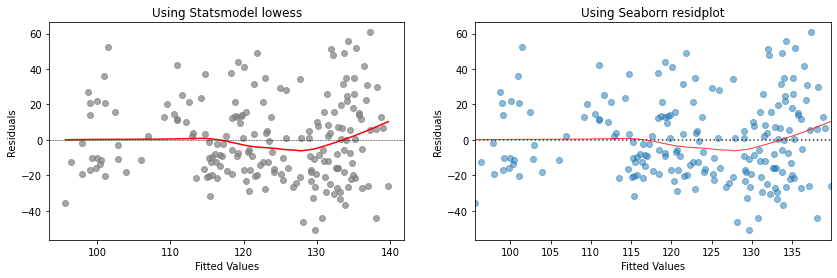

In [39]:
residuals = model.resid
y_hat = model.fittedvalues

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

ax0 = axs[0]
ax0.scatter(x=y_hat, y=residuals, color='gray', alpha=0.7)

fitted_lowess = lowess(residuals, y_hat)
ax0.plot(fitted_lowess[:, 0], fitted_lowess[:, 1], color='red')
ax0.axhline(y=0, linestyle='--', color='black', lw=0.5)
ax0.set_title('Using Statsmodel lowess')

ax1 = axs[1]
ax1.set_title('Using Seaborn residplot')
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, 
                     scatter_kws={'alpha': 0.5}, ax=ax1,
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

for ax in axs:
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel('Residuals')

plt.show()

Checking the normality of the residuals

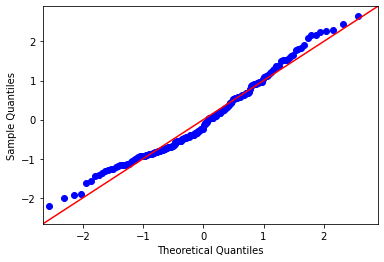

In [40]:
norm_residuals = (residuals - residuals.mean()) / residuals.std(ddof=4)
plot = sm.qqplot(norm_residuals, line='45')

Exploring the leverage of points using hat diagonals

count    192.000000
mean       0.021460
std        0.013828
min        0.006024
25%        0.011671
50%        0.017392
75%        0.026427
max        0.071672
dtype: float64


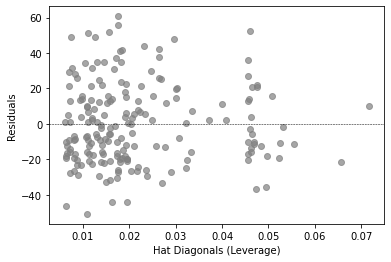

In [41]:
hat_diag = model.get_influence().hat_diag_factor

print(pd.Series(hat_diag).describe())

plt.axhline(y=0, linestyle='--', color='black', lw=0.5)
plt.scatter(x=hat_diag, y=residuals, color='gray', alpha=0.7)
plt.xlabel('Hat Diagonals (Leverage)')
plt.ylabel('Residuals')
plt.show()

Exploring the change in fitted values when leaving the observation out (See `dffits`)

count    192.000000
mean       0.001298
std        0.144666
min       -0.360694
25%       -0.100020
50%       -0.027350
75%        0.094652
max        0.510407
dtype: float64


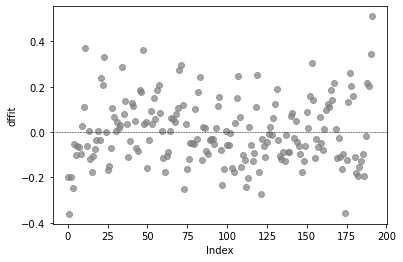

In [42]:
dffits = model.get_influence().dffits[0]
print(pd.Series(dffits).describe())

plt.axhline(y=0, linestyle='--', color='black', lw=0.5)
plt.scatter(x=np.arange(len(dffits)), y=dffits, color='gray', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('dffit')
plt.show()

Exploring changes in coefficients when excluding a point

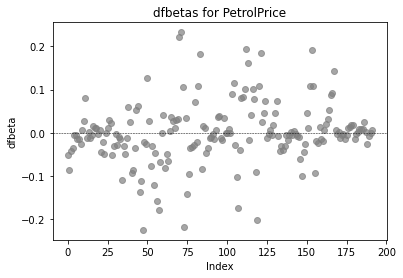

In [45]:
# Choose variable
var = 'PetrolPrice'

df_betas = model.get_influence().dfbetas
df_betas = pd.DataFrame(df_betas, columns=['const', 'kms', 'PetrolPrice', 'law'])

df_betas = df_betas[var]
plt.scatter(x=np.arange(df_betas.shape[0]), y=df_betas, color='gray', alpha=0.7)
plt.axhline(y=0, linestyle='--', color='black', lw=0.5)
plt.xlabel('Index')
plt.ylabel('dfbeta')
plt.title(f'dfbetas for {var}')
plt.show()

Exploring cooks distance, which takes into account changes in all coefficients for each point

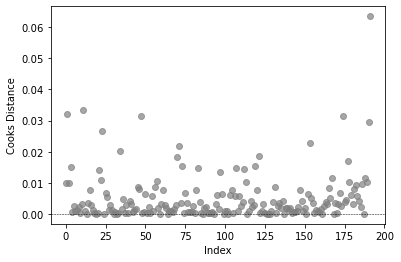

In [46]:
cooks_dist = model.get_influence().cooks_distance[0]

plt.axhline(y=0, linestyle='--', color='black', lw=0.5)
plt.scatter(x=np.arange(len(cooks_dist)), y=cooks_dist, color='gray', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Cooks Distance')
plt.show()

Checking the high value

In [47]:
max_val_index = np.argmax(cooks_dist)
print(X.loc[max_val_index])
X.describe()

const          1.000000
kms            3.570396
PetrolPrice    1.018584
law            1.000000
Name: 191, dtype: float64


,const,kms,PetrolPrice,law
count,192.0,1.920000e+02,1.920000e+02,192.000000
mean,1.0,2.544261e-16,5.421589e-15,0.119792
std,0.0,2.938049e+00,1.000000e+00,0.325567
min,1.0,-7.308604e+00,-1.843415e+00,0.000000
25%,1.0,-2.308604e+00,-9.072501e-01,0.000000
50%,1.0,-6.604167e-03,7.003078e-02,0.000000
75%,1.0,2.208896e+00,8.567388e-01,0.000000
max,1.0,6.632396e+00,2.414899e+00,1.000000


Plotting the point that had a high influence on the fitted values (high cook distance) on a plot between `kms` and `PetrolPrice`. The colors represent the `law` variable. There seems to be nothing unusual about this point based on the plot.

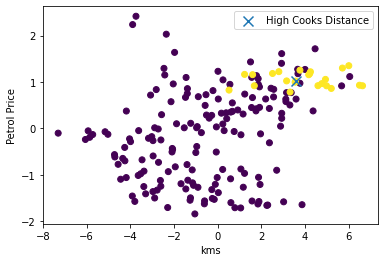

In [48]:
plt.scatter(x='kms', y='PetrolPrice', c='law', data=X, label=None)
plt.scatter(x=X.loc[max_val_index, 'kms'], y=X.loc[max_val_index, 'PetrolPrice'],
            marker='x', s=100, label='High Cooks Distance')

plt.xlabel('kms')
plt.ylabel('Petrol Price')
plt.legend()
plt.show()

### Model Selection
* Omitting variables that should have been included results in bias if these variables are correlated with other variables in our model. However, if the omitted variables are not correlated with other predictors we wouldn't have additional bias. However, we will not be able to explain some of the residual variance that we would have been able to explain if we included the omitted variable.

* Adding unnecessary variables results in an increase in the variance (real not estimated) of the coefficients of other variables. This increase in variance is much worse if the added variables correlate with the variables in the model. (See simulation in book). The variance inflation factor (VIF) measures the increase in the variance of the ith regressor compared to the ideal case when it is orthogonal to the other regressors (uncorrelated). 

In [51]:
# Loading swiss fertility data
df = pd.read_csv('data/swiss.csv')
df.head(2)

,Location,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
0,Courtelary,80.2,17.0,15,12,9.96,22.2
1,Delemont,83.1,45.1,6,9,84.84,22.2


In [52]:
def fit_model(data, target, predictors, intercept=True):
    X = data[predictors].copy()
    
    if intercept:
        X = sm.add_constant(X)
        
    y = data[target]
    
    model = sm.OLS(y, X).fit()
    
    return model

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

predictors = ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

X = df[predictors].copy()
X = sm.add_constant(X)

print('VIF:')
for i, col in enumerate(predictors):
    print(f'   {col}: {variance_inflation_factor(X.values, i+1):.3f}')
    
print('\nStandard Error Inflation:')
for i, col in enumerate(predictors):
    print(f'   {col}: {np.sqrt(variance_inflation_factor(X.values, i+1)):.3f}')

VIF:
   Agriculture: 2.284
   Examination: 3.675
   Education: 2.775
   Catholic: 1.937
   Infant.Mortality: 1.108

Standard Error Inflation:
   Agriculture: 1.511
   Examination: 1.917
   Education: 1.666
   Catholic: 1.392
   Infant.Mortality: 1.052


Simulating the increase in $R^2$ when increasing predictors, even if the predictors are meaningless.

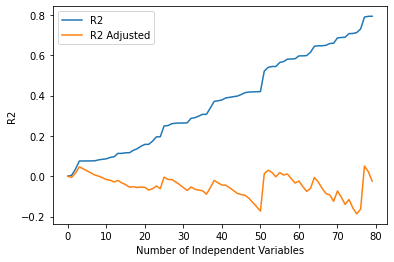

In [54]:
n_iter = 80
n = 100
y = np.random.randn(n)
X = np.zeros((n, n_iter))
X = sm.add_constant(X)

rsquared_arr = np.zeros((n_iter, 2))

for i in range(n_iter):
    model = sm.OLS(y, X[:, :i+1]).fit()
    rsquared_arr[i, 0] = model.rsquared
    rsquared_arr[i, 1] = model.rsquared_adj
    
    X[:, i+1] = np.random.randn(n)
    
plt.plot(np.arange(n_iter), rsquared_arr[:, 0], label='R2')
plt.plot(np.arange(n_iter), rsquared_arr[:, 1], label='R2 Adjusted')
plt.xlabel('Number of Independent Variables')
plt.ylabel('R2')

plt.legend()
plt.show()

**Choosing a model for drivers killed per month dataset**

In this dataset, we are interested in knowing the effect of the compulsory seatbelt law (`law`) on the number of drivers killed per month. Therefore, our focus should be on this variable.

In [56]:
df = pd.read_csv('data/seatbelts.csv', index_col=[0]).reset_index(drop=True)
df.head(2)

,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,107,1687,867,269,9059,0.102972,12,0
1,97,1508,825,265,7685,0.102363,6,0


In [57]:
y = df['DriversKilled']
X = df[['law', 'kms', 'PetrolPrice']].copy()

# Normalizing PetrolPrice
X['PetrolPrice'] = (X['PetrolPrice'] - X['PetrolPrice'].mean()) / (X['PetrolPrice'].std())

# Centering kms and dividing by 1000
X['kms'] = (X['kms'] - X['kms'].mean()) / 1000

# Adding constant
X = sm.add_constant(X)

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
predictors = list(X.columns[1:])

print('VIF:')
for i, col in enumerate(predictors):
    print(f'   {col}: {variance_inflation_factor(X.values, i+1):.3f}')

VIF:
   law: 1.406
   kms: 1.397
   PetrolPrice: 1.252


There is no significant multicollinearity

In [59]:
# Fitting nested models
for i in range(3):
    model = sm.OLS(y, X.iloc[:, :i+2]).fit()
    print(f'Model {i+1}:')
    print(f'   Predictors: {predictors[:i+1]}')
    print(f'   Coefficients:\n{model.summary().tables[1]}')
    print('\n')

Model 1:
   Predictors: ['law']
   Coefficients:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.8698      1.849     68.082      0.000     122.223     129.517
law          -25.6090      5.342     -4.794      0.000     -36.146     -15.072


Model 2:
   Predictors: ['law', 'kms']
   Coefficients:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.9049      1.853     67.424      0.000     121.251     128.559
law          -17.5537      6.029     -2.912      0.004     -29.446      -5.661
kms           -1.8196      0.668     -2.724      0.007      -3.137      -0.502


Model 3:
   Predictors: ['law', 'kms', 'PetrolPrice']
   Coefficients:
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [60]:
X_test = X[['const', 'PetrolPrice', 'law']]
model = sm.OLS(y, X_test).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,124.7578,1.789,69.736,0.000,121.229,128.287
PetrolPrice,-7.7354,1.809,-4.277,0.000,-11.303,-4.168
law,-16.3262,5.556,-2.939,0.004,-27.285,-5.367


Using the `law` variable on its own, we see that enacting the law resulted in 25 less deaths per month. However, some of these variation was explained by the other two variables when included (notice the change in `law` coefficient).

When including both `PetrolPrice` and `kms`, `kms` becomes insignificant (p-value=0.068). Therefore, it seems like the model should include `law` and one of `PetrolPrice` or `kms` (Not sure how to choose which). In both cases, enacting the seatbelt law reduced (presumably) deaths by about 17 people per month.

See Brian Caffo's solution [here](https://www.youtube.com/watch?v=ffu80TAq2zY&list=PLpl-gQkQivXji7JK1OP1qS7zalwUBPrX0&index=46).